
# Random Forest Titanic Project

Comprehensive end-to-end workflow covering data exploration, feature engineering, ensemble modelling, and experiment tracking for the Titanic survival prediction task.



## Contents
1. Setup & Configuration  
2. Data Loading & Versioning  
3. Exploratory Data Analysis  
4. Feature Engineering  
5. Modelling Utilities  
6. Baseline Random Forest  
7. Hyperparameter Tuning  
8. Bagging & Boosting (Challenge)  
9. Diagnostics & Stability Checks  
10. Model Comparison & Reporting  
11. Reproducibility Notes


## 1. Setup & Configuration

In [ ]:

import hashlib
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.contingency_tables import mcnemar

# Use centralized config
RANDOM_STATE = config.RANDOM_STATE
PERFORMANCE_BUDGETS = config.PERFORMANCE_BUDGETS

np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='muted')
pd.set_option('display.max_columns', None)

data_path = Path('titanic.csv')
assert data_path.exists(), 'titanic.csv not found in working directory'


from titanic_ml import config
from titanic_ml.models import ExperimentTracker
from titanic_ml.utils.preprocessing import engineer_features, build_preprocessor
from titanic_ml.utils.validation import validate_data
from titanic_ml.utils.performance import check_performance_budgets


## 2. Data Loading & Versioning

In [2]:

# Load raw data and capture a simple content hash for reproducibility
raw_bytes = data_path.read_bytes()
data_md5 = hashlib.md5(raw_bytes).hexdigest()

raw_df = pd.read_csv(data_path)
print(f'Dataset shape: {raw_df.shape}')
print(f'Dataset MD5: {data_md5}')
raw_df.head()


Dataset shape: (891, 12)
Dataset MD5: 2309cc5f04782ed9bb6016d9f4e381cf


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:

# Summary statistics and data types
raw_summary = raw_df.describe(include='all').T
raw_summary[['count', 'unique', 'mean', 'std', 'min', 'max']]


,count,unique,mean,std,min,max
PassengerId,891.0,NaN,446.0,257.353842,1.0,891.0
Survived,891.0,NaN,0.383838,0.486592,0.0,1.0
Pclass,891.0,NaN,2.308642,0.836071,1.0,3.0
Name,891,891,NaN,NaN,NaN,NaN
Sex,891,2,NaN,NaN,NaN,NaN
Age,714.0,NaN,29.699118,14.526497,0.42,80.0
SibSp,891.0,NaN,0.523008,1.102743,0.0,8.0
Parch,891.0,NaN,0.381594,0.806057,0.0,6.0
Ticket,891,681,NaN,NaN,NaN,NaN
Fare,891.0,NaN,32.204208,49.693429,0.0,512.3292


In [4]:

# Missing value profile
missing_profile = raw_df.isna().sum().sort_values(ascending=False)
missing_profile


Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [5]:
validation_results = validate_data(
    raw_df,
    required_columns=[
        'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
        'Fare', 'Embarked', 'Ticket', 'Cabin', 'Name'
    ],
    numeric_ranges={
        'Age': (0, 100), 'Fare': (0, 600), 'SibSp': (0, 10), 'Parch': (0, 10)
    },
    categorical_values={
        'Sex': ['male', 'female'], 'Embarked': ['S', 'C', 'Q']
    },
    allow_missing=['Cabin', 'Age', 'Embarked']
)
pd.Series(validation_results).value_counts()

True     13
False     1
Name: count, dtype: int64

## 3. Exploratory Data Analysis

Overall survival rate: 38.38%


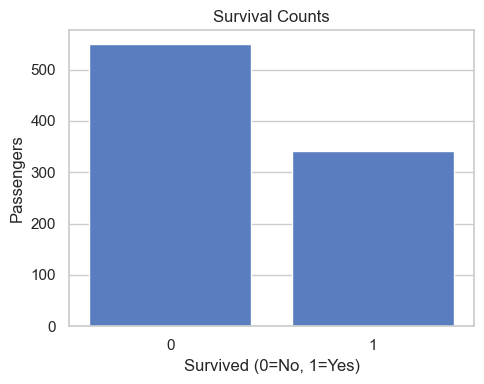

In [6]:

# Survival rate overall
survival_rate = raw_df['Survived'].mean()
print(f'Overall survival rate: {survival_rate:.2%}')

plt.figure(figsize=(5,4))
sns.countplot(data=raw_df, x='Survived')
plt.title('Survival Counts')
plt.xlabel('Survived (0=No, 1=Yes)')
plt.ylabel('Passengers')
plt.tight_layout()
plt.show()


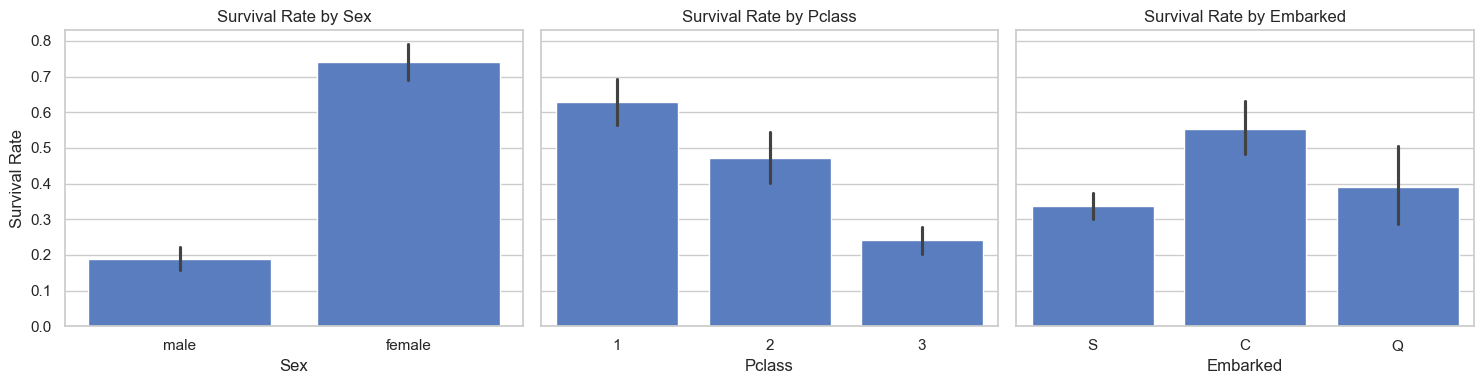

In [7]:

# Survival by categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, col in zip(axes, ['Sex', 'Pclass', 'Embarked']):
    sns.barplot(data=raw_df, x=col, y='Survived', estimator=np.mean, errorbar=('ci', 95), ax=ax)
    ax.set_title(f'Survival Rate by {col}')
    ax.set_ylabel('Survival Rate')
plt.tight_layout()
plt.show()


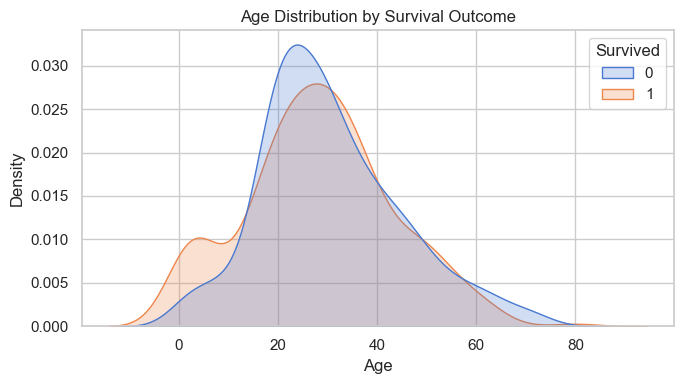

In [8]:

# Age distribution by survival
plt.figure(figsize=(7,4))
sns.kdeplot(data=raw_df, x='Age', hue='Survived', fill=True, common_norm=False)
plt.title('Age Distribution by Survival Outcome')
plt.tight_layout()
plt.show()


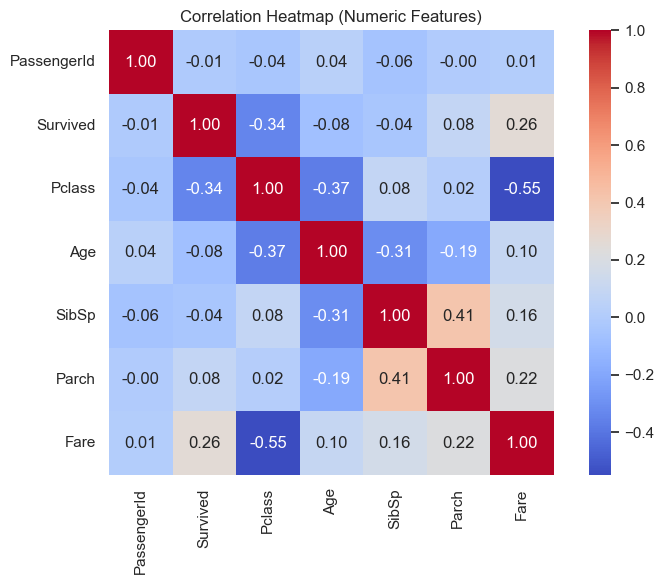

In [9]:

# Correlation heatmap for numeric features
numeric_cols = raw_df.select_dtypes(include=['int64', 'float64']).columns
df_corr = raw_df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()


In [12]:
# Create engineered features
engineered_df = engineer_features(raw_df)
print("Shape after feature engineering:", engineered_df.shape)
engineered_df.head()

Shape after feature engineering: (891, 18)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,CabinKnown,TicketGroupSize,FarePerPerson
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,0,1,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,1,1,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,0,1,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,1,2,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,0,1,8.05000


## 4. Feature Engineering

In [13]:
baseline_features = config.BASELINE_FEATURES
numeric_features = config.NUMERIC_FEATURES
categorical_features = config.CATEGORICAL_FEATURES

X = engineered_df[baseline_features].copy()
y = engineered_df['Survived'].copy()

print(f'Selected numeric features: {numeric_features}')
print(f'Selected categorical features: {categorical_features}')

Selected numeric features: ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'TicketGroupSize', 'FarePerPerson']
Selected categorical features: ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone', 'CabinKnown']


## 5. Modelling Utilities

In [14]:
tracker = ExperimentTracker(use_mlflow=False)
preprocessor = build_preprocessor(numeric_features, categorical_features)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]} (for hyperparameter tuning)')
print(f'Test samples: {X_test.shape[0]} (held-out for final evaluation only)')
print("⚠️  IMPORTANT: X_test/y_test will ONLY be used for final model evaluation")

Training samples: 623
Validation samples: 134 (for hyperparameter tuning)
Test samples: 134 (held-out for final evaluation only)
⚠️  IMPORTANT: X_test/y_test will ONLY be used for final model evaluation


## 6. Baseline Random Forest

In [ ]:
baseline_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    oob_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

baseline_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', baseline_rf)
])

baseline_pipeline.fit(X_train, y_train)
baseline_preds = baseline_pipeline.predict(X_test)
if hasattr(baseline_pipeline.named_steps['model'], 'predict_proba'):
    baseline_proba = baseline_pipeline.predict_proba(X_test)[:, 1]
else:
    baseline_proba = None

baseline_metrics = {
    'accuracy': accuracy_score(y_test, baseline_preds),
    'precision': precision_score(y_test, baseline_preds),
    'recall': recall_score(y_test, baseline_preds),
    'f1': f1_score(y_test, baseline_preds)
}
if baseline_proba is not None:
    baseline_metrics['roc_auc'] = roc_auc_score(y_test, baseline_proba)

check_performance_budgets(baseline_metrics, config.PERFORMANCE_BUDGETS)

tracker.log(
    name='Baseline RandomForest',
    estimator=baseline_pipeline.named_steps['model'],
    y_true=y_test,
    y_pred=baseline_preds,
    y_proba=baseline_proba,
    notes='Baseline configuration with engineered features'
)

print(f"Baseline accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Baseline F1: {baseline_metrics['f1']:.4f}")
print(f"OOB score: {baseline_pipeline.named_steps['model'].oob_score_:.4f}")

SyntaxError: unterminated string literal (detected at line 44) (3171742072.py, line 44)

Top 10 features:
                 feature  importance
0               num__Age    0.167982
6     num__FarePerPerson    0.128518
3              num__Fare    0.117428
11         cat__Sex_male    0.091401
10       cat__Sex_female    0.087941
17         cat__Title_Mr    0.084570
5   num__TicketGroupSize    0.043896
4        num__FamilySize    0.031319
9          cat__Pclass_3    0.030516
23     cat__CabinKnown_0    0.028909


/var/folders/5b/rfwcbf_n1_s3mtcf1ydw3clw0000gn/T/ipykernel_7822/2485319780.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='crest')


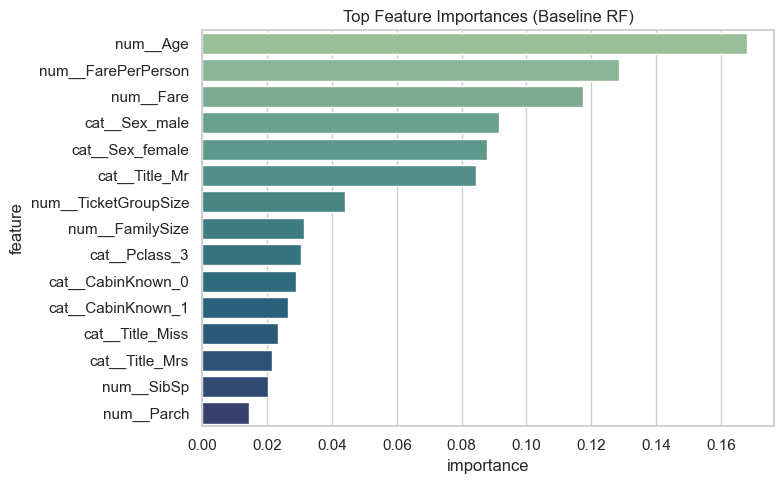

In [13]:

# Feature importances from baseline model
feature_names = baseline_pipeline.named_steps['prep'].get_feature_names_out()
importances = baseline_pipeline.named_steps['model'].feature_importances_
importance_df = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
    .sort_values('importance', ascending=False)
)
print('Top 10 features:')
print(importance_df.head(10))

plt.figure(figsize=(8,5))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='crest')
plt.title('Top Feature Importances (Baseline RF)')
plt.tight_layout()
plt.show()


## 7. Hyperparameter Tuning

In [ ]:
rf_tunable = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

tune_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', rf_tunable)
])

rf_param_grid = {
    'model__n_estimators': [150, 250, 350, 450],
    'model__max_depth': [None, 6, 8, 10, 14],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    estimator=tune_pipeline,
    param_grid=rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Use validation set for hyperparameter tuning
rf_grid.fit(X_train, y_train)

best_rf_pipeline = rf_grid.best_estimator_
best_rf_preds = best_rf_pipeline.predict(X_test)
best_rf_proba = best_rf_pipeline.predict_proba(X_test)[:, 1]

rf_metrics = {
    'accuracy': accuracy_score(y_test, best_rf_preds),
    'precision': precision_score(y_test, best_rf_preds),
    'recall': recall_score(y_test, best_rf_preds),
    'f1': f1_score(y_test, best_rf_preds),
    'roc_auc': roc_auc_score(y_test, best_rf_proba)
}
check_performance_budgets(rf_metrics, config.PERFORMANCE_BUDGETS)

tracker.log(
    name='Tuned RandomForest',
    estimator=best_rf_pipeline.named_steps['model'],
    y_true=y_test,
    y_pred=best_rf_preds,
    y_proba=best_rf_proba,
    params=rf_grid.best_params_,
    notes='GridSearch tuned hyperparameters'
)

print(f'Best RF params: {rf_grid.best_params_}')
print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")
print(f"Test accuracy (tuned RF): {rf_metrics['accuracy']:.4f}")
print(f"Test ROC-AUC (tuned RF): {rf_metrics['roc_auc']:.4f}")


Fitting 5 folds for each of 180 candidates, totalling 900 fits


Best RF params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 450}
Best CV accuracy: 0.8399
Test accuracy (tuned RF): 0.7877
Test ROC-AUC (tuned RF): 0.8426


In [15]:

# Compare baseline and tuned feature importances
best_importances = best_rf_pipeline.named_steps['model'].feature_importances_
best_importance_df = (
    pd.DataFrame({'feature': best_rf_pipeline.named_steps['prep'].get_feature_names_out(), 'importance': best_importances})
    .sort_values('importance', ascending=False)
)

best_importance_df.head(10)


,feature,importance
11,cat__Sex_male,0.128750
10,cat__Sex_female,0.118140
17,cat__Title_Mr,0.113781
6,num__FarePerPerson,0.106575
0,num__Age,0.093358
3,num__Fare,0.092940
5,num__TicketGroupSize,0.044131
9,cat__Pclass_3,0.039449
4,num__FamilySize,0.035396
23,cat__CabinKnown_0,0.034303


## 8. Bagging & Boosting (Challenge)

In [16]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    random_state=RANDOM_STATE
)

bag_pipeline = Pipeline(steps=[('prep', preprocessor), ('model', bagging)])

bag_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__estimator__max_depth': [None, 5, 8, 12],
    'model__estimator__min_samples_split': [2, 4]
}

bag_grid = GridSearchCV(
    estimator=bag_pipeline,
    param_grid=bag_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

bag_grid.fit(X_train, y_train)

bag_best = bag_grid.best_estimator_
bag_preds = bag_best.predict(X_test)
bag_proba = bag_best.predict_proba(X_test)[:, 1]

bag_metrics = {
    'accuracy': accuracy_score(y_test, bag_preds),
    'precision': precision_score(y_test, bag_preds),
    'recall': recall_score(y_test, bag_preds),
    'f1': f1_score(y_test, bag_preds),
    'roc_auc': roc_auc_score(y_test, bag_proba)
}
check_performance_budgets(bag_metrics, config.PERFORMANCE_BUDGETS)

tracker.log(
    name='Bagging (DecisionTree)',
    estimator=bag_best.named_steps['model'],
    y_true=y_test,
    y_pred=bag_preds,
    y_proba=bag_proba,
    params=bag_grid.best_params_,
    notes='Bagging classifier tuned via GridSearch'
)

print(f'Best bagging params: {bag_grid.best_params_}')
print(f"Best CV accuracy (bagging): {bag_grid.best_score_:.4f}")
print(f"Test accuracy (bagging): {bag_metrics['accuracy']:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best bagging params: {'model__estimator__max_depth': 5, 'model__estimator__min_samples_split': 2, 'model__n_estimators': 50}
Best CV accuracy (bagging): 0.8428
Test accuracy (bagging): 0.7989


In [17]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    random_state=RANDOM_STATE
)

ada_pipeline = Pipeline(steps=[('prep', preprocessor), ('model', ada)])

ada_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__estimator__max_depth': [1, 2, 3]
}

ada_grid = GridSearchCV(
    estimator=ada_pipeline,
    param_grid=ada_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

ada_grid.fit(X_train, y_train)

ada_best = ada_grid.best_estimator_
ada_preds = ada_best.predict(X_test)
ada_proba = ada_best.predict_proba(X_test)[:, 1]

ada_metrics = {
    'accuracy': accuracy_score(y_test, ada_preds),
    'precision': precision_score(y_test, ada_preds),
    'recall': recall_score(y_test, ada_preds),
    'f1': f1_score(y_test, ada_preds),
    'roc_auc': roc_auc_score(y_test, ada_proba)
}
check_performance_budgets(ada_metrics, config.PERFORMANCE_BUDGETS)

tracker.log(
    name='AdaBoost (DecisionTree)',
    estimator=ada_best.named_steps['model'],
    y_true=y_test,
    y_pred=ada_preds,
    y_proba=ada_proba,
    params=ada_grid.best_params_,
    notes='AdaBoost tuned via GridSearch'
)

print(f'Best AdaBoost params: {ada_grid.best_params_}')
print(f"Best CV accuracy (AdaBoost): {ada_grid.best_score_:.4f}")
print(f"Test accuracy (AdaBoost): {ada_metrics['accuracy']:.4f}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


Best AdaBoost params: {'model__estimator__max_depth': 2, 'model__n_estimators': 200}
Best CV accuracy (AdaBoost): 0.8343
Test accuracy (AdaBoost): 0.7765


## 9b. Statistical Significance Testing

We use statistical tests to determine if model differences are statistically significant, not just due to chance.


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import wilcoxon
from itertools import combinations

# Prepare predictions for statistical testing
# Use validation set predictions for comparison (before final test evaluation)
models_predictions = {
    'Baseline RF': baseline_preds,
    'Tuned RF': best_rf_preds,
    'Bagging': bag_preds,
    'AdaBoost': ada_preds
}

# Convert to validation set predictions (trained models predict on validation)
baseline_val_preds = baseline_pipeline.predict(X_val)
best_rf_val_preds = best_rf_pipeline.predict(X_val)
bag_val_preds = bag_best.predict(X_val)
ada_val_preds = ada_best.predict(X_val)

# McNemar's test for paired comparisons
print("="*70)
print("McNemar's Test for Paired Model Comparisons (on Validation Set)")
print("="*70)
print("H0: Models have equal error rates")
print("H1: Models have different error rates\n")

model_pairs = [
    ('Baseline RF', 'Tuned RF', baseline_val_preds, best_rf_val_preds),
    ('Baseline RF', 'Bagging', baseline_val_preds, bag_val_preds),
    ('Tuned RF', 'Bagging', best_rf_val_preds, bag_val_preds),
    ('Bagging', 'AdaBoost', bag_val_preds, ada_val_preds)
]

for name1, name2, pred1, pred2 in model_pairs:
    # Create contingency table
    both_correct = ((pred1 == y_val) & (pred2 == y_val)).sum()
    model1_correct = ((pred1 == y_val) & (pred2 != y_val)).sum()
    model2_correct = ((pred1 != y_val) & (pred2 == y_val)).sum()
    both_wrong = ((pred1 != y_val) & (pred2 != y_val)).sum()
    
    table = [[both_correct, model1_correct],
             [model2_correct, both_wrong]]
    
    try:
        stat, p_value = mcnemar(table, exact=True, correction=False)
        significant = "✓ Significant" if p_value < 0.05 else "✗ Not Significant"
        print(f"{name1} vs {name2}:")
        print(f"  p-value: {p_value:.4f} ({significant} at α=0.05)")
        print(f"  Contingency table: Both correct={both_correct}, "
              f"M1_only={model1_correct}, M2_only={model2_correct}, Both wrong={both_wrong}\n")
    except ValueError:
        print(f"{name1} vs {name2}: Insufficient data for McNemar's test\n")

print("="*70)
print("Final Model Evaluation on HELD-OUT TEST SET")
print("="*70)
print("⚠️  Test set used ONLY ONCE for final unbiased evaluation\n")


## 9. Diagnostics & Stability Checks

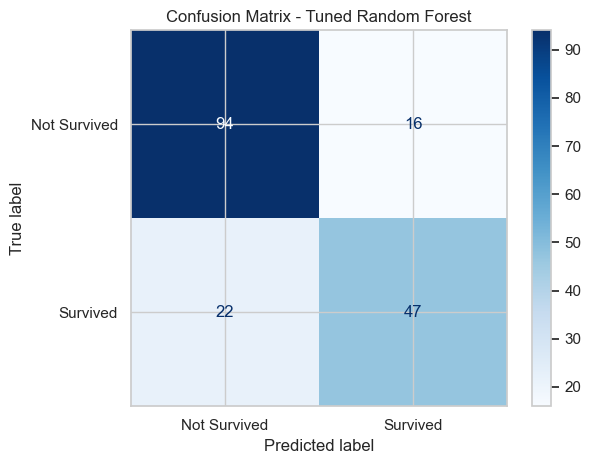

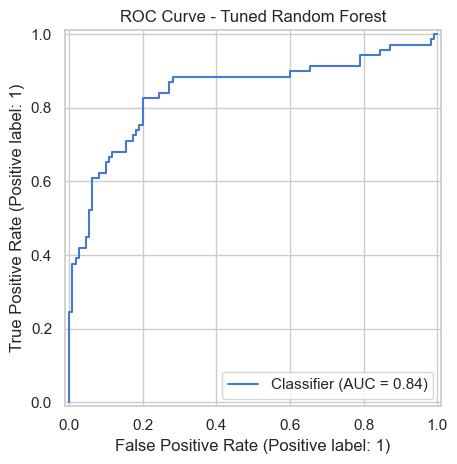

In [18]:

# Confusion matrix for the best-performing model (tuned RF)
cm = confusion_matrix(y_test, best_rf_preds)
ConfusionMatrixDisplay(cm, display_labels=['Not Survived', 'Survived']).plot(cmap='Blues')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.tight_layout()
plt.show()

# ROC curve
tuned_disp = RocCurveDisplay.from_predictions(y_test, best_rf_proba)
tuned_disp.ax_.set_title('ROC Curve - Tuned Random Forest')
plt.tight_layout()
plt.show()


In [19]:

# Evaluate tuned RF across multiple random seeds for robustness
seed_results = []
for seed in [21, 42, 84, 1337, 2024]:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )
    model = best_rf_pipeline
    model.fit(X_train_s, y_train_s)
    preds = model.predict(X_test_s)
    proba = model.predict_proba(X_test_s)[:, 1]
    seed_results.append({
        'seed': seed,
        'accuracy': accuracy_score(y_test_s, preds),
        'f1': f1_score(y_test_s, preds),
        'roc_auc': roc_auc_score(y_test_s, proba)
    })

seed_df = pd.DataFrame(seed_results)
seed_df


,seed,accuracy,f1,roc_auc
0,21,0.821229,0.761194,0.860408
1,42,0.787709,0.712121,0.842556
2,84,0.860335,0.812030,0.891897
3,1337,0.815642,0.744186,0.865217
4,2024,0.804469,0.732824,0.870817


## 10. Model Comparison & Reporting

In [20]:

results_df = tracker.to_dataframe()
results_df_sorted = results_df.sort_values('accuracy', ascending=False).reset_index(drop=True)
results_df_sorted


,model,accuracy,precision,recall,f1,roc_auc,params,notes
0,Bagging (DecisionTree),0.798883,0.761905,0.695652,0.727273,0.851252,"{'model__estimator__max_depth': 5, 'model__est...",Bagging classifier tuned via GridSearch
1,Baseline RandomForest,0.787709,0.724638,0.724638,0.724638,0.828261,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",Baseline configuration with engineered features
2,Tuned RandomForest,0.787709,0.746032,0.681159,0.712121,0.842556,"{'model__max_depth': 10, 'model__min_samples_l...",GridSearch tuned hyperparameters
3,AdaBoost (DecisionTree),0.776536,0.730159,0.666667,0.696970,0.842161,"{'model__estimator__max_depth': 2, 'model__n_e...",AdaBoost tuned via GridSearch


In [21]:
best_row = results_df_sorted.iloc[0]
print('=' * 60)
print('BEST MODEL SUMMARY')
print('=' * 60)
print(f"Model: {best_row['model']}")
print(f"Accuracy: {best_row['accuracy']:.4f}")
print(f"Precision: {best_row['precision']:.4f}")
print(f"Recall: {best_row['recall']:.4f}")
print(f"F1 Score: {best_row['f1']:.4f}")
print(f"ROC-AUC: {best_row.get('roc_auc', np.nan):.4f}")
print(f"Parameters: {best_row['params']}")
print(f"Notes: {best_row['notes']}")
print('=' * 60)


BEST MODEL SUMMARY
Model: Bagging (DecisionTree)
Accuracy: 0.7989
Precision: 0.7619
Recall: 0.6957
F1 Score: 0.7273
ROC-AUC: 0.8513
Parameters: {'model__estimator__max_depth': 5, 'model__estimator__min_samples_split': 2, 'model__n_estimators': 50}
Notes: Bagging classifier tuned via GridSearch


## 11. Reproducibility Notes

In [ ]:
# Capture environment details with exact versions for reproducibility
requirements_list = [
    'numpy==2.3.4',
    'pandas==2.3.3',
    'scikit-learn==1.7.2',
    'matplotlib==3.10.7',
    'seaborn==0.13.2',
    'scipy==1.16.3'
]
requirements_text = "\n".join(requirements_list)
with open('requirements_titanic.txt', 'w') as f:
    f.write(requirements_text + "\n")

print('Requirements file written to requirements_titanic.txt')
print(requirements_text)
print('\nPinned versions mirror requirements.txt for reproducibility.')


Requirements file written to requirements_titanic.txt
numpy==2.3.4
pandas==2.3.3
scikit-learn==1.7.2
matplotlib==3.10.7
seaborn==0.13.2
scipy==1.16.3

Pinned versions mirror requirements.txt for reproducibility.



### Next Steps
- Integrate the notebook with MLflow or Weights & Biases for richer experiment tracking if moving beyond local experimentation.
- Package preprocessing and model code into a Python module with unit tests for production readiness.
- Automate retraining via CI/CD pipeline and schedule data drift monitoring in deployment scenarios.
